In [413]:
from importlib import reload
import static_model
reload(static_model)
from static_model import *

In [414]:
import networkx as nx
import numpy as np
import torch

In [415]:
import wntr
import pandas as pd

inp_file = 'network_file.inp'
emitter_coeffs = [0]
results_list = []
flow_list = []

for coeff in emitter_coeffs:
    wn = wntr.network.WaterNetworkModel(inp_file)
    junction = wn.get_node('JUNCTION-0')
    junction.emitter_coefficient = coeff

    sim = wntr.sim.EpanetSimulator(wn)
    results = sim.run_sim()

    head = results.node['head'].iloc[0]
    pressure = results.node['pressure'].iloc[0]
    demand = results.node['demand'].iloc[0]
    
    print(50 - pressure['JUNCTION-0'])


    df = pd.DataFrame({
        'Emitter Coefficient': coeff,
        'Head (m)': head,
        'Pressure (m)': pressure,
        'Demand (m³/s)': demand,
    })

    results_list.append(df)
    
    flow = results.link['flowrate'].iloc[0]  # Take the flowrate at first time step
    flow_df = pd.DataFrame({
        'Emitter Coefficient': coeff,
        'Pipe': flow.index,
        'Flowrate (m³/s)': flow.values
    })

    flow_list.append(flow_df)

final_results = pd.concat(results_list, keys=emitter_coeffs, names=["Leak Scenario", "Element"])
pipe_flows = pd.concat(flow_list, ignore_index=True)
display(final_results)
display(pipe_flows)


0.009857177734375


Emitter Coefficient   Head (m)  Pressure (m)  \
Leak Scenario Element                                                    
0             JUNCTION-0                    0  49.990143  4.999014e+01   
              RESERVOIR                     0  50.000000 -7.812500e-07   

                          Demand (m³/s)  
Leak Scenario Element                    
0             JUNCTION-0           0.05  
              RESERVOIR           -0.05

,Emitter Coefficient,Pipe,Flowrate (m³/s)
0,0,PIPE-0,0.05


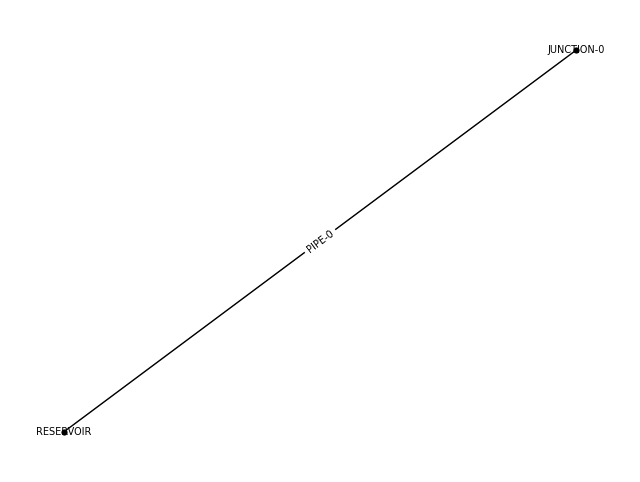

In [416]:
from wntr.graphics import plot_network
import matplotlib.pyplot as plt

# Plot just the structure of the network
fig, ax = plt.subplots(figsize=(8, 6))
plot_network(wn, node_labels=True, link_labels=True, ax=ax)
plt.show()

In [417]:
G = wn.to_graph()
A = nx.incidence_matrix(G)
reservoirs = list(wn.reservoir_name_list)
# Get all node names (junctions, tanks, reservoirs)
all_nodes = list(G.nodes())

# Filter out reservoirs
non_reservoir_nodes = [n for n in all_nodes if n not in reservoirs]

idx = [i for i, n in enumerate(all_nodes) if n not in reservoirs]

# Get adjacency matrix using filtered nodelist
A  = nx.incidence_matrix(G)
A0 = torch.tensor(A[idx,:].toarray(), dtype=torch.float32)



In [418]:
from scipy.sparse import dok_matrix

edgelist = list(G.edges())
supply_nodes = wn.reservoir_name_list  # or include tanks if needed
supply_nodes = list(supply_nodes)  # Ensure it's ordered

# Create edge-to-start-node mapping
edge_start_nodes = [edge[0] for edge in edgelist]

# Create B matrix (|E| x |supply_nodes|), sparse
B = dok_matrix((len(edgelist), len(supply_nodes)), dtype=int)

for i, (start_node) in enumerate(edge_start_nodes):
    if start_node in supply_nodes:
        j = supply_nodes.index(start_node)
        B[i, j] = 1

# Convert to CSR format for efficient arithmetic
B = torch.tensor(B.toarray(), dtype=torch.float32)

In [419]:
junctions = wn.junction_name_list  # Only junctions have demand

# Get base demands at each junction
D_values = []
for name in junctions:
    junction = wn.get_node(name)
    demand = junction.base_demand  # in m³/s
    D_values.append(demand)

# D is a NumPy array aligned with junction_name_list
D = torch.tensor(D_values, dtype=torch.float32)
print(D)

tensor([0.0500])


In [420]:
# Get supply node names
supply_nodes = wn.reservoir_name_list  # Or include tanks if needed

# Get heads at each supply node
S_values = []
for name in supply_nodes:
    reservoir = wn.get_node(name)
    head = reservoir.base_head  # This is constant in steady state
    S_values.append(head)

S = torch.tensor(S_values, dtype=torch.float32)
print(S)


tensor([50.])


In [421]:
pipe_names = wn.pipe_name_list  # List of all pipe IDs

# Get length of each pipe (in meters)
L = torch.tensor([wn.get_link(name).length for name in pipe_names], dtype=torch.float32)

# Get diameter of each pipe (in meters)
d = torch.tensor([wn.get_link(name).diameter for name in pipe_names], dtype=torch.float32)

# Get Hazen-Williams roughness coefficients (unitless)
C = torch.tensor([wn.get_link(name).roughness for name in pipe_names], dtype=torch.float32)

print(C)

tensor([100.])


In [422]:
model_params = {
    'A0': A0,
    'B' : B,
    'A_max' : 0.0,
    'S' : S,
    'D' : D,
    'd': d,
    'L': L,
    'Cd' : 0.75, 
    'C' : C,
    'rho' : 1000.0,
    'n_samples' : 1
}

net_params = {
     'layer_sizes' : [1, 42, 42, 42], 
     'activation' : 'relu',
}

In [423]:
model = Model(model_params, net_params)
model.train(iterations=100000, print_interval=100)

step       loss       e1          e2
100        2.42e+03   6.79e-03   2.42e+03        New Best!
200        2.40e+03   5.78e-02   2.40e+03        New Best!
300        2.36e+03   1.59e-01   2.36e+03        New Best!
400        2.31e+03   3.08e-01   2.31e+03        New Best!
500        2.26e+03   5.03e-01   2.26e+03        New Best!
600        2.19e+03   7.40e-01   2.19e+03        New Best!
700        2.12e+03   1.02e+00   2.12e+03        New Best!
800        2.05e+03   1.33e+00   2.05e+03        New Best!
900        1.97e+03   1.69e+00   1.96e+03        New Best!
1000       1.88e+03   2.07e+00   1.88e+03        New Best!
1100       1.79e+03   2.49e+00   1.79e+03        New Best!
1200       1.70e+03   2.94e+00   1.70e+03        New Best!
1300       1.61e+03   3.41e+00   1.61e+03        New Best!
1400       1.52e+03   3.91e+00   1.52e+03        New Best!
1500       1.43e+03   4.43e+00   1.42e+03        New Best!
1600       1.34e+03   4.97e+00   1.33e+03        New Best!
1700       1.25e+03

In [424]:
A = torch.zeros((1, 1))


H = model.Hnet(A)
q = model.qnet(A)

print(H.item())
print(q.item())

49.990142822265625
0.05000026524066925
